# **[Multi-Agent Reinforcement Learning Schema for Dynamic Traffic Assignment](https://github.com/Team4IDS576/class-project/)**

---

# Introduction

The 4-step transportation modeling process is a systematic approach used in urban and transportation planning to analyze and optimize transportation systems. The process involves four key stages: (1) Trip Generation, where the total number of trips originating in each zone of the network is estimated; (2) Trip Distribution, which determines the origins and destinations of these trips, and creates the OD matrix; (3) Mode Choice, where the transportation mode for each trip is selected; and (4) Traffic Assignment, the critical step that assigns trips to specific routes in the transportation network, considering factors like road capacity, congestion, and travel time. The last step is a dynamic and competitive process. This traffic assignment problem (TAP) becomes vital due to the finite road resources available (supply), leading travelers to compete for the most efficient routes to minimize their travel times (Shou et al.). The intricacies of road congestion underscore the interconnectivity of travelers' decisions, where the choices of one driver can significantly impact the travel times of others (Grunitzki et al.).

Conventionally, TAP employs one of two key concepts: User Equilibrium (UE) or System Optimum (SO). UE posits that the assignment process is akin to a Markov game with a Nash equilibrium solution, where no individual can enhance their travel time by independently altering their route choice (Sheffi). Nevertheless, it's recognized that Nash equilibria frequently lead to suboptimal outcomes when compared to socially optimal assignments (Zhou et al.). SO, on the other hand, is achievable only when all motorists collectively opt for actions that minimize the total system travel time rather than prioritizing their individual travel times (Sheffi).
Traditional TAP, whether considering UE or System SO, is typically addressed through mathematical modeling and solving (Zhou et al.). However, this approach often necessitates the use of simplifying assumptions, resulting in models that may diverge from real-world complexities. Moreover, these models are often difficult to solve. Therefore, in this project, our goal is to employ a Reinforcement Learning (RL) framework to model route choice behavior. This approach treats route selection as an adaptive decision-making process situated within a complex environment, enabling the model to learn optimal actions through iterative interactions with its surroundings.


# Methodology

Reinforcement learning (RL) revolves around the challenge of enabling an agent to acquire behavior through dynamic interactions with its environment. Typically, the RL problem is characterized by a set of states ($S$), actions ($A$), a state transition function ($T$), and a reward function ($R$) that yields the reward $R(s,a)$ following a specific action. The primary objective is to determine a policy ($π$) that maximizes the agent's cumulative future rewards. At each state, the agent faces the crucial choice of either exploiting familiar actions or exploring new alternatives, potentially leading to the discovery of more advantageous actions (Grunitzki et al.).

In this research, we explore the realm of partially observable Markov games (POMDPs), an extension of Markov decision processes (MDPs) tailored for multi-agent scenarios. A POMDP involving $N$ agents is characterized by a set of states $S$, indicating possible configurations of all agents, as well as distinct sets of actions $A_1, \dots, A_N$ and observations $O_1, \dots, O_N$ for each agent. Each agent $i$ employs a stochastic policy $\pi_i: O_i \times A_i \to [0, 1]$ to determine actions, influencing the subsequent state through the state transition function $T: S \times A_1 \times \dots \times A_N \to S$. Rewards for each agent $i$ are contingent on the state and the agent's action, denoted as $r_i: S \times A_i \to \mathbb{R}$, and private observations correlated with the state are received as $o_i: S \to O_i$. Initial states are determined by a distribution function $\rho: S \to [0, 1]$. The primary objective for each agent $i$ is to maximize its individual total expected return $R_i = \sum_{t=0}^T \gamma^t r_i(s_t, a_i(t))$, where $\gamma$ serves as the discount factor, and $T$ represents the time horizon (Lowe et al.).

In this problem, a state ($s \in S$) comprises two main components: the node and the time. For an agent currently in the state $s=(n,t)$, the available actions ($a \in A$) can either be selecting one of the outbound links from the node or, alternatively, utilizing one of the predefined routes from the origin to the destination. The reward function is defined as a negative value representing the travel cost associated with the state transition. This reward function is designed so that as travel time decreases, the reward increases, motivating drivers to seek to minimize their travel times (Shou et al.).

To simulate the interaction of agents in the transportation network, we employed the parallel API of the PettingZoo library, a Python toolkit designed for multi-agent environment research. This library offers diverse environments that replicate scenarios involving cooperative and competitive interactions among agents. Built on the foundation of OpenAI Gym, a toolkit for developing and benchmarking reinforcement learning algorithms, PettingZoo extends Gym's capabilities to cater specifically to multi-agent environments. This integration makes the library well-suited for the needs of this research.

This study employs the Multi-Agent Deep Deterministic Policy Gradient (MADDPG) approach, recognizing the limitations of traditional reinforcement learning algorithms like Q-learning and Policy Gradient in addressing multi-agent challenges. The issue lies in the dynamic nature of individual agents' policies during training, leading to non-stationarity in the environment and hindering straightforward use of past experience replay (Lowe et al.). Additionally, policy gradient methods exhibit high variance when coordinating multiple agents. To overcome these challenges, a general-purpose multi-agent learning algorithm is adopted, facilitating cooperative or competitive training in complex environments (Lowe et al.). This choice enhances learning stability and convergence by utilizing decentralized actor and centralized critic architectures.

## Network initialization

First, we need to define the network as well as the latency (travel time) function based on the flow on the link. This code defines a simulation framework for a transportation network using the NetworkX library. 
The network is based on the Nguyen network model, which includes intersections, roads, and traffic flow. 
### nguyenNetwork
* Reads road network data from CSV files, creates a directed graph representing intersections and roads, and initializes road attributes.
* Returns a NetworkX DiGraph representing the Nguyen network.

In [ ]:
import networkx as nx
import pandas as pd

def nguyenNetwork(high=True):
    
    # Read the CSV file into a DataFrame
    data_types = {"start node": str, "end node": str} # node names should be str
    
    # for mac OS
    if high == True:
        links = pd.read_csv("./network/NguyenLinksHighDemand200.csv", dtype=data_types)
    else:
        links = pd.read_csv("./network/NguyenLinksLowDemand50.csv", dtype=data_types)
    
    links['flow'] = 0
    
    # instantiate null directed graph
    network = nx.DiGraph()
    
    # initialize intersections
    intersections = {
        "1": {"pos": (1, 3)},
        "2": {"pos": (4, 1)},
        "3": {"pos": (3, 0)},
        "4": {"pos": (0, 2)},
        "5": {"pos": (1, 2)},
        "6": {"pos": (2, 2)},
        "7": {"pos": (3, 2)},
        "8": {"pos": (4, 2)},
        "9": {"pos": (1, 1)},
        "10": {"pos": (2, 1)},
        "11": {"pos": (3, 1)},
        "12": {"pos": (2, 3)},
        "13": {"pos": (2, 0)}
    }

    # add intersections
    for node, attrs in intersections.items():
        network.add_node(node, **attrs)
    
    # intialize roads

    # Create a list of tuples from the DataFrame
    roads = [(row["start node"], 
              row["end node"], 
              {"ffs": row["free flow speed"], 
               "capacity": row["capacity"],
               "alpha": row["alpha"],
               "beta": row["beta"],
               "latency": row["latency"],
               "flow": row["flow"]}) for _, row in links.iterrows()]

    # Print the list of roads
    # print(roads)


    # add roads
    network.add_edges_from(roads)
    
    return network

### latency function

* Calculates the latency (travel time) on a road segment based on the Bureau of Public Roads (BPR) function, considering flow, capacity, and other parameters.
* Parameters:
  - flow: Total number of vehicles on the road.
  - start_node and end_node: Identifiers for the start and end nodes of the road.
* Returns the rounded travel time for the given road segment.

In [ ]:
def latency(flow, start_node, end_node):
    network = nguyenNetwork()
    edge_data = network.get_edge_data(str(start_node), str(end_node))
    
    # 'flow' takes the total No. of vehicle in the link
    # 'start_node' and 'end_node' should be integer values
    # This function assumes that the travel time of the links are BPR functions.
    # for more information about BPR functions read p#358 of Sheffi's book.
    c = edge_data['capacity']
    t_0 = edge_data['ffs']
    a = edge_data['alpha']
    b = edge_data['beta']
    t_link = t_0 * (1 + (a * ((flow/c) ** b)))
    return round(t_link) # this function only returns integer values

### traffic_f function

* Generates synthetic traffic demand based on CSV files, creating a list of agents with origins and destinations.
* Returns a dictionary containing information about agents, their origins, and destinations.

In [ ]:
def traffic_f(high=True):
    if high == True:
        demand = pd.read_csv("./network/NguyenDemandHighDemand200.csv")
    else:
        demand = pd.read_csv("./network/NguyenLowDemand50.csv")
    agents = []
    origins = []
    destinations = []
    agent_no = 0

    for index, row in demand.iterrows():
        origin = str(row['Origin'])
        destination = str(row['Destination'])
        count = int(row['OD demand'])
        for i in range(count):
            agent_no += 1
            agents.append(f'agent_{agent_no}')
            origins.append(origin)
            destinations.append(destination)

    traffic = {
        "agents": agents,
        "origins": origins,
        "destinations": destinations
    }

    return traffic

## Road Network Environment

This code defines a custom environment for simulating traffic assignment on the Nguyen network using the Gymnasium and PettingZoo libraries. 
The environment is designed for multi-agent reinforcement learning (MARL) scenarios.

In [ ]:
import gymnasium
from gymnasium.spaces import Box, Dict, Discrete
from gymnasium.spaces.utils import flatten_space
from gymnasium.utils import EzPickle
import numpy as np

from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers
from pettingzoo.utils.conversions import parallel_wrapper_fn


# allows to import the parallel environment using "from NguyenNetworkEnv import parallel_env"
__all__ = ["ManualPolicy", "env", "parallel_env", "raw_env"]

# environment wrapper
def env(**kwargs):
    env = raw_env(**kwargs)
    env = wrappers.OrderEnforcingWrapper(env)
    return env

* Environment Initialization: Sets up the Nguyen Network environment with traffic demand from agents.

* Observation Space: Defines the observation space for each agent, considering the network structure and latency information.

* Action Space: Defines the action space for each agent, representing the choice of road routes.

* Step Function: Simulates one step in the environment for the agents, updating their positions, rewards, and other state information.

* Reset Function: Resets the environment to its initial state.

* Additional Functions:
  - observe(agent): Generates observations for a given agent based on its current position and neighbors.
  - state(): Returns an array-like object for logging, containing termination triggers and agent travel times.

In [ ]:
# AEC to parallel wrapper
parallel_env = parallel_wrapper_fn(env)
class raw_env(AECEnv):
    metadata = {
        "name": "NguyenNet",
        "is_parallelizable": True
    }
    
    """
    This is the traffic assignment environment. More documentation to follow.
    """
    
    # initialize environment with the Nguyen Network and Traffic Demand from agents
    def __init__(
        self,
        net = nguyenNetwork(),
        traffic = traffic_f(high=False),
        render_mode = None
        ):
        
        # no rendering at the moment
        self.render_mode = render_mode
        
        # initialize network from Nguyen Network
        self.road_network = net
        self.traffic = traffic
        
        # initialize agents
        self.agents = self.traffic["agents"] # list of agents in environment
        self.possible_agents = self.agents[:]
        self.agent_name_mapping = dict(zip(self.agents, list(range(len(self.agents)))))
        self._agent_selector = agent_selector(self.agents)
        
        # check
        self.terminations_check = dict(zip(self.agents, [False for _ in self.agents]))
        self.truncations_check = dict(zip(self.agents, [False for _ in self.agents]))
        self.termination_trigger = dict(zip(self.agents, [False for _ in self.agents]))
        self.truncation_trigger = dict(zip(self.agents, [False for _ in self.agents]))
        
        # agent origin, destination, and location information
        self.agent_origins = self.traffic["origins"].copy()
        self.agent_origin_backup = self.traffic["origins"].copy()
        self.agent_locations = self.traffic["origins"].copy()
        self.agent_destinations = self.traffic["destinations"]
        self.agent_path_histories = {agent: [location] for agent, location in zip(self.agents, self.agent_locations)}
        self.agent_wait_time = {agent: 0 for agent in self.agents}
        self.agent_travel_time = {agent: 0 for agent in self.agents}

        # agent unflattened observation space, this is flattened alphabetically btw.
        self.unflattened_observation_spaces = {
            agent: Dict({
                "observation": Box(low=-1, high=12, shape=(2,1), dtype=int),
                "latencies": Box(low=0, high=30, shape=(2,1), dtype=int),
                "location": Box(low = 0, high = 12, shape = (1,1), dtype=int),
            }) for agent in self.agents
        }
        
        # agent flattened observatino space
        self.observation_spaces = {
            i: flatten_space(self.unflattened_observation_spaces[i]) for i in self.unflattened_observation_spaces
        }
        
        # agent action space
        self.action_spaces = dict(
            # with the nguyen network agents have at most 2 choices
            zip(
                self.agents,
                [gymnasium.spaces.Discrete(2)]*len(self.agents)
            )
        )
        
        # agent terminal and truncated states
        self.terminate = False
        self.truncate = False
        
    def observation_space(self, agent):
        return self.observation_spaces[agent]
    
    def action_space(self, agent):
        return self.action_spaces[agent]
    
    def observe(self, agent):

        agent_idx = self.agent_name_mapping[agent]
        
        # get possible nodes the agent can travel to
        agent_position = self.agent_locations[agent_idx]
        agent_node_neighbors = list(self.road_network.neighbors(agent_position))
        
        # encode position
        position = []
        encoding = int(self.agent_locations[agent_idx])-1
        position.append(encoding)
        
        # encode node positions
        node_encoded = []
        for node in agent_node_neighbors:
            encoding = int(node)-1
            node_encoded.append(encoding)
        
        # currently using ffs attribute, need to revise to use updated latency
        # neighboring_nodes_ffs = []
        # for node in agent_node_neighbors:
        #     ffs_value = self.road_network.get_edge_data(agent_position, node)["ffs"]
        #     neighboring_nodes_ffs.append(ffs_value)

        # updated to use "latency" instead of "ffs"
        neighboring_nodes_latencies = []
        for node in agent_node_neighbors:
            latency_value = self.road_network.get_edge_data(agent_position, node)["latency"]
            neighboring_nodes_latencies.append(latency_value)

        # return observation – a list in structured as [node1, latency1, node 2, latency2]
        if len(agent_node_neighbors) == 1:
            node_encoded = node_encoded*2
            # neighboring_nodes_ffs = neighboring_nodes_ffs*2
            neighboring_nodes_latencies = neighboring_nodes_latencies*2
        if len(agent_node_neighbors) == 0:
            node_encoded = [-1,-1]
            # neighboring_nodes_ffs = [0,0]
            neighboring_nodes_latencies = [0,0]
            
        # observations  = np.array(neighboring_nodes_ffs+position+node_encoded)
        observations = np.array(neighboring_nodes_latencies + position + node_encoded)
        
        return observations



    def state(self) -> np.ndarray:
        """We need to return an np-array like object for logging"""
        return list(self.termination_trigger.values()), list(self.agent_travel_time.values())



    def step(self, action):
        """This does not work"""
        # # check if agent is dead
        # if (
        #     self.terminations_check[self.agent_selection] or
        #     self.truncations_check[self.agent_selection]
        # ):
        #     # self.rewards[self.agent_selection] = 0
        #     self.agent_selection = self._agent_selector.next()
        #     #self._accumulate_rewards()
        #     return
        
        action = np.asarray(action)
        agent = self.agent_selection
        agent_idx = self.agent_name_mapping[agent]        

        self._cumulative_rewards[agent] = 0
        
        if self._agent_selector.is_last():
            # Track the count of agents on each link for all agents' positions
            agents_on_link = {edge: 0 for edge in self.road_network.edges()}
            # print(agents_on_link)
            # print(self.road_network.edges())

            # Update the count based on all agents' neighbors
            for current_agent in self.agents:                   
                agent_idx = self.agent_name_mapping[current_agent]                
                agent_position = self.agent_locations[agent_idx]                
                agent_node_neighbors = list(self.road_network.neighbors(agent_position))

                for node in agent_node_neighbors:                    
                    for edge in zip([agent_position], [node]):                        
                        agents_on_link[edge] += 1  # Increment count when an agent enters a link                                  

            for edge, agent_count in agents_on_link.items():                
                link_data = self.road_network.get_edge_data(*edge)  
                # print(link_data) # not updated                                       

                flow = agent_count  # 'flow' takes the total number of vehicles in the link                                         
                start_node = np.int64(edge[0])            
                end_node = np.int64(edge[1])            

                new_latency = latency(flow, start_node, end_node)                       
                link_data["latency"] = new_latency            
                # print(new_latency)                   

                self.road_network[edge[0]][edge[1]]["latency"] = new_latency
                # print(f"Updated latency for edge {edge}: {self.road_network[edge[0]][edge[1]]['latency']}") 

            self._clear_rewards()
        else:
            self._clear_rewards()
            pass

        # agent travel decrement
        if self.agent_wait_time[agent] != 0:
            # if agent has waiting time (i.e. "traveling" along edge, decrement wait time by one time step)
            self.agent_wait_time[agent] -= 1
            self.agent_selection = self._agent_selector.next()
            self._accumulate_rewards()
            return
        
        # agent reaches terminal state
        if self.agent_locations[agent_idx] == self.agent_destinations[agent_idx]:
            self.terminations_check[agent] = True
            
            # return reward for arriving at destionation
            if self.termination_trigger[agent] == False:
                completion_reward = 100
                self.termination_trigger[agent] = True
            else:
                completion_reward = 0
            
            self.rewards[agent] = completion_reward
            self.agent_selection = self._agent_selector.next()
            self._accumulate_rewards()
            return
        
        # agent reaches truncation state
        if self.agent_locations[agent_idx] != self.agent_destinations[agent_idx] and \
        (self.agent_locations[agent_idx] == "2" or self.agent_locations[agent_idx] == "3"):
            self.truncations_check[agent] = True
                    
            # return penalty for arriving at wrong destination
            if self.truncation_trigger[agent] == False:
                completion_penalty = -100
                self.truncation_trigger[agent] = True
            else:
                completion_penalty = 0
                
            self.rewards[agent] = completion_penalty
            self.agent_selection = self._agent_selector.next()
            self._accumulate_rewards()
            return
        
        # agent chooses action
        choices =  list(
            self.road_network.neighbors(
                self.agent_locations[agent_idx]
            )
        )
        
        # if only one route
        if len(choices) == 1:
            choices = [choices[0], choices[0]]
        
        # select action
        chosen_route = choices[action]

        # reward based on chosen route latency, again using ffs instead of calculated latency, need a _calculate_reward(agent) method for this
        reward = self.road_network.get_edge_data(
            self.agent_locations[agent_idx],
            # chosen_route)["ffs"]
            chosen_route)["latency"]
        
        # add negative latency to reward – DQN to maximize negative reward
        self.rewards[agent] = -1*reward
        
        # update latency
        self.agent_wait_time[agent] += reward
        self.agent_travel_time[agent] += reward        
        
        # update agent position
        self.agent_locations[agent_idx] = chosen_route
        
        # update path history
        self.agent_path_histories[agent].append(chosen_route)
        
        
        # set the next agent to act
        self.agent_selection = self._agent_selector.next()
        self._accumulate_rewards()


    def reset(self, seed=None, options=None):
        # reset to initial states
        self.agent_origins = self.agent_origin_backup.copy()
        self.agent_locations = self.agent_origin_backup.copy()
        self.agent_path_histories = {agent: [location] for agent, location in zip(self.agents, self.agent_origins)}
        self.agent_wait_time = {agent: 0 for agent in self.agents}
        self.agent_travel_time = {agent: 0 for agent in self.agents} # added

        self.agents = self.possible_agents[:]        
        self._agent_selector.reinit(self.agents)
        self.agent_selection = self._agent_selector.next()
        self.terminate = False
        self.truncate = False
        self.rewards = dict(zip(self.agents, [0 for _ in self.agents]))
        self._cumulative_rewards = {a: 0 for a in self.agents}
        self.terminations = dict(zip(self.agents, [False for _ in self.agents]))
        self.truncations = dict(zip(self.agents, [False for _ in self.agents]))
        self.infos = dict(zip(self.agents, [{} for _ in self.agents]))
        
        # Reset termination and truncation checks
        # check
        self.terminations_check = dict(zip(self.agents, [False for _ in self.agents]))
        self.truncations_check = dict(zip(self.agents, [False for _ in self.agents]))
        self.termination_trigger = dict(zip(self.agents, [False for _ in self.agents]))
        self.truncation_trigger = dict(zip(self.agents, [False for _ in self.agents]))
        
        # Reset road network-related variables
        # print("Resetting latency values")
        for edge in self.road_network.edges():
            start_node, end_node = edge
            self.road_network[start_node][end_node]["latency"] = 0            

        # Clear any existing rewards
        #self._clear_rewards()
        # print(self.rewards)
        # print(self.state())

        # Return the initial state
        #return self.state()

## Train agileRL

This code implements a Multi-Agent Deep Deterministic Policy Gradients (MADDPG) algorithm to address traffic control in road networks, specifically the Nguyen Network. The environment is constructed using Gymnasium and PettingZoo libraries, and the MADDPG algorithm is employed to train a group of agents to navigate through the network.

### Environment Setup:

* Initializes the Nguyen Network environment and sets up the MADDPG algorithm.
* Components:
  - Environment instantiation (env).
  - Configuration of algorithm input parameters.
  - Creation of a multi-agent replay buffer (memory).
  - Saving device information to a file (device_info.txt).

In [ ]:
# import RoadNetEnv
import pandas as pd
import torch
import numpy as np
from agilerl.components.multi_agent_replay_buffer import MultiAgentReplayBuffer
from agilerl.algorithms.maddpg import MADDPG

# instantiate env and torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# env = RoadNetEnv.parallel_env()
env = parallel_env()
env.reset()

# configure algo input parameters
try:
    state_dim = [env.observation_space(agent).n for agent in env.agents]
    one_hot = True
except Exception:
    state_dim = [env.observation_space(agent).shape for agent in env.agents]
    one_hot = False
try:
    action_dim = [env.action_space(agent).n for agent in env.agents]
    discrete_actions = True
    max_action = None
    min_action = None
except Exception:
    action_dim = [env.action_space(agent).shape[0] for agent in env.agents]
    discrete_actions = False
    max_action = [env.action_space(agent).high for agent in env.agents]
    min_action = [env.action_space(agent).low for agent in env.agents]

n_agents = env.num_agents
agent_ids = [agent_id for agent_id in env.agents]
done = {agent_id: False for agent_id in env.agents}
field_names = ["state", "action", "reward", "next_state", "done"]
memory = MultiAgentReplayBuffer(
    memory_size=1000000,
    field_names=field_names,
    agent_ids=agent_ids,
    device=device
)

with open('device_info.txt', 'w') as file:
	file.write(f"Device: {device}")

NET_CONFIG = {
    "arch": "mlp",
    "h_size": [128, 128]
}

### MADDPG Algorithm Configuration

* Configures the MADDPG algorithm with the necessary hyperparameters and network architecture.
* Components:
  - Configuration of state and action dimensions.
  - Instantiation of the MADDPG agent (agent) with specified parameters.
  - Loading a pre-trained checkpoint if available.

In [ ]:
agent = MADDPG(
    state_dims=state_dim,
    action_dims=action_dim,
    one_hot=one_hot,
    n_agents=n_agents,
    agent_ids=agent_ids,
    max_action=max_action,
    min_action=min_action,
    discrete_actions=True,
    device=device,
    net_config=NET_CONFIG,
    lr=1e-2,
    batch_size=8,
    gamma=0.99,  
    expl_noise=0.2,

    # lr=1e-3,  # Learning Rate for Optimizer (defaults to 0.01)
    # batch_size=128, # Batch Size (defaults to 64)    
    # tau=0.005, # Soft Update Parameter (Tau, defaults to 0.01)
    # gamma=0.99,  # Discount Factor (Gamma, defaults to 0.95)
    # expl_noise=0.2,  # Exploration Noise (defaults to 0.1)

)


# load checkpoint
# agent.loadCheckpoint("./checkpoint/checkpoint_60.pt")

episodes = 200
max_steps = 50
epsilon = 1.0
eps_end = 0.1
eps_decay = 0.995

episode_travel_times = []

log_interval = 10
start_ep = 1

### Training Loop

* Executes the main training loop for a specified number of episodes.
  - Loop over episodes and steps within each episode.
  - Interaction with the environment to obtain states, actions, rewards, and next states.
  - Saving experiences to the replay buffer.
  - Periodic learning of the agents based on sampled experiences from the replay buffer.
  - Metric logging, including episode rewards and travel times.

In [ ]:
for ep in range(episodes):
    state, info = env.reset()
    agent_reward = {agent_id: 0 for agent_id in env.agents}
    
    for i in range(max_steps):
        agent_mask = info["agent_mask"] if "agent_mask" in info.keys() else None
        env_defined_actions = (
            info["env_defined_actions"]
            if "env_defined_actions" in info.keys()
            else None
        )
        
        # get next action from agent
        cont_actions, discrete_action = agent.getAction(
            state, epsilon, agent_mask, env_defined_actions
        )
        if agent.discrete_actions:
            action = discrete_action
        else:
            action = cont_actions
        
        # act in environment
        next_state, reward, termination, truncation, info = env.step(
            action
        )
        
        # save experience to replay buffer
        memory.save2memory(state, cont_actions, reward, next_state, done)
        
        for agent_id, r in reward.items():
            agent_reward[agent_id] += r
        
        # learn according to learning frequency
        if (memory.counter % agent.learn_step == 0) and (len(memory) >= agent.batch_size):
            experiences = memory.sample(agent.batch_size)
            agent.learn(experiences)
            
        # update state
        state = next_state

    # metric logging
    finishers, travel_time = env.state()
    episode_travel_times.append(travel_time) # export to csv
    
    # save the total episode reward
    score = sum(agent_reward.values())
    agent.scores.append(score)
    
    
    # update epsilon for exploration
    epsilon = max(eps_end, epsilon * eps_decay)

    if (ep+start_ep) % log_interval == 0 or ep == episodes -1:
        reward_scores = pd.DataFrame(agent.scores)
        reward_scores.to_csv(f"./results/reward_{ep+start_ep}.csv")
        travel_times = pd.DataFrame(episode_travel_times)
        travel_times.to_csv(f"./results/travel_times_{ep+start_ep}.csv")
        agent.saveCheckpoint(f"./checkpoint/checkpoint_{ep+start_ep}.pt")  



# Numerical Example

The model's effectiveness presented in this study is demonstrated by applying it to a real-world transportation network. Transportation networks are graphs where nodes represent intersections, and links correspond to roads through which traffic flows. Each link is associated with a latency function, typically a non-linear function (e.g., the commonly used BPR function), which models the travel time of the link based on its traffic flow (Shou et al.). The equation shows the BPR function:
$$t_i(x_i) = t_0(1+\alpha(\dfrac{x_i}{C_i})^\beta)$$
where $t_i$ is the travel time of link $i$, $t_0$ is the travel time with free flow speed, $x_i$ is the flow in the link, $C_i$ is the capacity of the link, and $\alpha$ and $\beta$ are coefficients. In this study, we employed the Nguyen–Dupuis network to evaluate the model, a well-established benchmark in similar research efforts (Zhou et al.). This network comprises 13 nodes, 19 links, 25 routes, and 4 origin-destination (O-D) pairs as is shown in Figure 1.

<figure align = "center">
<img src="https://raw.githubusercontent.com/Team4IDS576/class-project/main/network/NguyenNetwork.jpg" style="width:50%">
<figcaption align = "center"> Figure 1. The Nguyen and Dupuis network </figcaption>
</figure>

In this network, nodes 1 and 3 serve as origins, while nodes 2 and 3 function as destinations, resulting in four O-D pairs, each with its specific demands. Following the UE principle, post-assignment, the travel times for the utilized routes within each O-D pair should be equivalent to one another and surpass the travel time of the unused routes.

We also intend to conduct a comparative analysis of our Multi-Agent Reinforcement Learning (MARL) solution method with traditional approaches to evaluate its accuracy and effectiveness. To facilitate this comparison, we leveraged AequilibraE, a Python package designed for transportation modeling (AequilibraE), to perform the traffic assignment within the network and subsequently compare the obtained results. This comparative assessment will help us gauge the performance and advantages of our novel MARL approach in the context of transportation modeling.

Given the computational expense associated with training an RL model, we found it practical to employ a simpler model initially for adjusting hyperparameters and other code-related elements before transitioning to a more intricate example. To facilitate this, we utilized two distinct demand files: a low-demand file involving 50 agents for quick training and a high-demand scenario with 100 agents representing the final model. Table 1 delineates the demand for each O-D pair. Additionally, we adjusted link capacities in accordance with the demands to ensure consistent congestion scenarios in both cases. Table 2 provides details regarding the links in the network for both scenarios.

**Table 1:** Demand for Each O-D Pair

|O-D | low-demand | high-demand |
|:-:|:-:|:-:|
|1-2 | 13         | 25          |
|1-3 | 10         | 19          |
|4-2 | 15         | 31          |
|4-3 | 12         | 25          |

**Table 2:** Network Link Characteristics

| Link No. | Start Node | End Node | Free Flow Speed | Alpha | Beta | Capacity High-Demand | Capacity Low-Demand |
|----------|------------|----------|------------------|-------|------|----------------------|---------------------|
| 1        | 1          | 12       | 7                | 0.15  | 4    | 7                    | 5                   |
| 2        | 1          | 5        | 9                | 0.15  | 4    | 9                    | 4                   |
| 3        | 4          | 5        | 9                | 0.15  | 4    | 9                    | 4                   |
| 4        | 4          | 9        | 12               | 0.15  | 4    | 12                   | 4                   |
| 5        | 5          | 9        | 3                | 0.15  | 4    | 3                    | 6                   |
| 6        | 5          | 6        | 9                | 0.15  | 4    | 9                    | 7                   |
| 7        | 9          | 10       | 5                | 0.15  | 4    | 5                    | 9                   |
| 8        | 9          | 13       | 13               | 0.15  | 4    | 13                   | 4                   |
| 9        | 6          | 7        | 2                | 0.15  | 4    | 2                    | 4                   |
| 10       | 12         | 8        | 9                | 0.15  | 4    | 9                    | 5                   |
| 11       | 10         | 11       | 9                | 0.15  | 4    | 9                    | 9                   |
| 12       | 13         | 3        | 10               | 0.15  | 4    | 10                   | 9                   |
| 13       | 12         | 6        | 9                | 0.15  | 4    | 9                    | 4                   |
| 14       | 6          | 10       | 6                | 0.15  | 4    | 6                    | 7                   |
| 15       | 7          | 11       | 9                | 0.15  | 4    | 9                    | 5                   |
| 16       | 7          | 8        | 8                | 0.15  | 4    | 8                    | 5                   |
| 17       | 11         | 2        | 7                | 0.15  | 4    | 7                    | 4                   |
| 18       | 11         | 3        | 14               | 0.15  | 4    | 14                   | 5                   |
| 19       | 8          | 2        | 11               | 0.15  | 4    | 11                   | 4                   |


# Results

## Low Demand (50 agents)

In [1]:
# Library
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
# Load Travel Time Data
df = pd.read_csv('travel_times_200.csv', index_col = 0)

In [6]:
# Calculate Stats
df_stat = pd.DataFrame()
df_stat['avg'] = df.mean(axis = 1)
df_stat['std'] = df.std(axis = 1)
df_stat['md'] = df.median(axis = 1)
df_stat['min'] = df.min(axis = 1)
df_stat['max'] = df.max(axis = 1)
df_stat['CI'] = df_stat['std'] * 1.96 / len(df.columns)
df_stat['IQR'] = df.quantile(0.75, axis = 1) - df.quantile(0.25, axis = 1)
df_stat['3rdQ'] = df_stat['md'] + df_stat['IQR']
df_stat['1stQ'] = df_stat['md'] - df_stat['IQR']
df_stat['upper'] = df_stat['avg'] + df_stat['CI']
df_stat['lower'] = df_stat['avg'] - df_stat['CI']
# df_stat

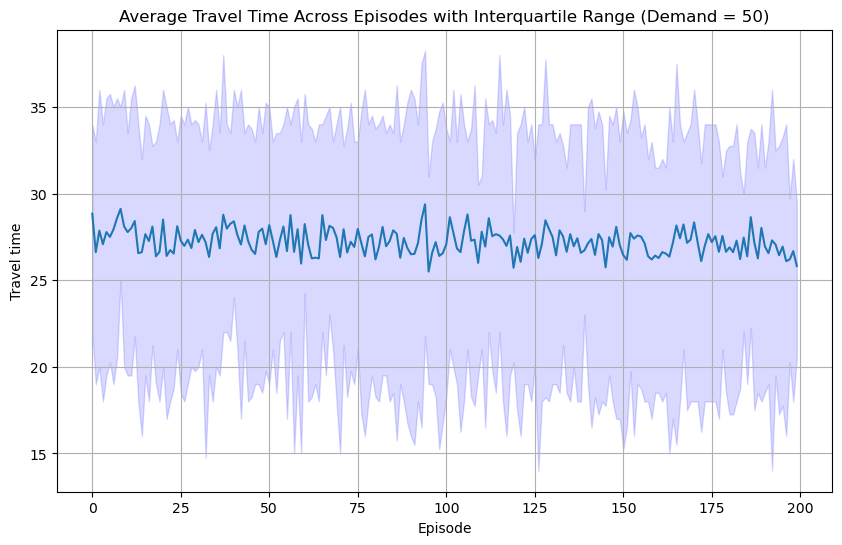

In [9]:
# Plot the Figure
fig, ax = plt.subplots(figsize=(10,6))
x = range(len(df))
ax.plot(x, df_stat['avg'])
# ax.plot(x, df_stat['md'])
ax.fill_between(
    x, df_stat['1stQ'], df_stat['3rdQ'], color='b', alpha=.15)

ax.set_title('Average Travel Time Across Episodes with Interquartile Range (Demand = 50)')
ax.grid()
plt.xlabel('Episode')
plt.ylabel('Travel time')
plt.savefig('AvgTT50.png')

In [12]:
# Load Reward Data
df_r = pd.read_csv('reward_200.csv', index_col = 0)

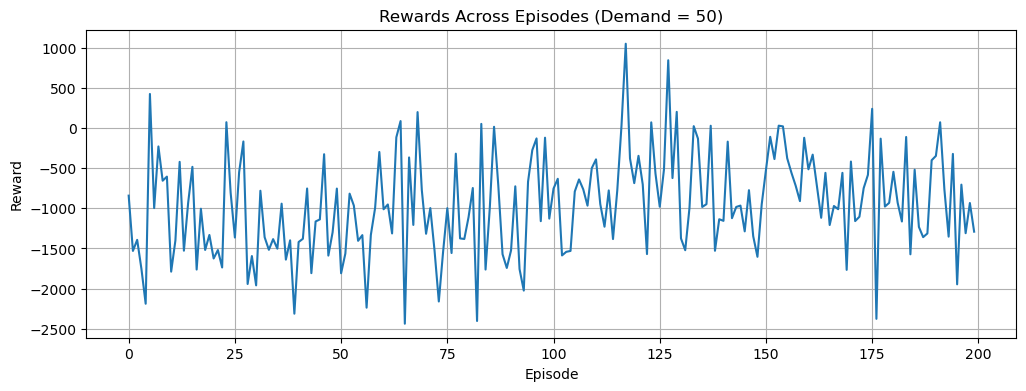

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
x = range(len(df_r))
ax.plot(x, df_r['0'])
ax.set_title('Rewards Across Episodes (Demand = 50)')
ax.grid()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig('Rewards50.png')

## Medium Demand (100 agents)

In [3]:
# Load Travel Time Data
df3 = pd.read_csv('episode_travel_times_3.csv', index_col = 0)
df = df3

In [4]:
# Calculate Stats
df_stat = pd.DataFrame()
df_stat['avg'] = df.mean(axis = 1)
df_stat['std'] = df.std(axis = 1)
df_stat['md'] = df.median(axis = 1)
df_stat['min'] = df.min(axis = 1)
df_stat['max'] = df.max(axis = 1)
df_stat['CI'] = df_stat['std'] * 1.96 / len(df.columns)
df_stat['IQR'] = df.quantile(0.75, axis = 1) - df.quantile(0.25, axis = 1)
df_stat['3rdQ'] = df_stat['md'] + df_stat['IQR']
df_stat['1stQ'] = df_stat['md'] - df_stat['IQR']
df_stat['upper'] = df_stat['avg'] + df_stat['CI']
df_stat['lower'] = df_stat['avg'] - df_stat['CI']
# df_stat

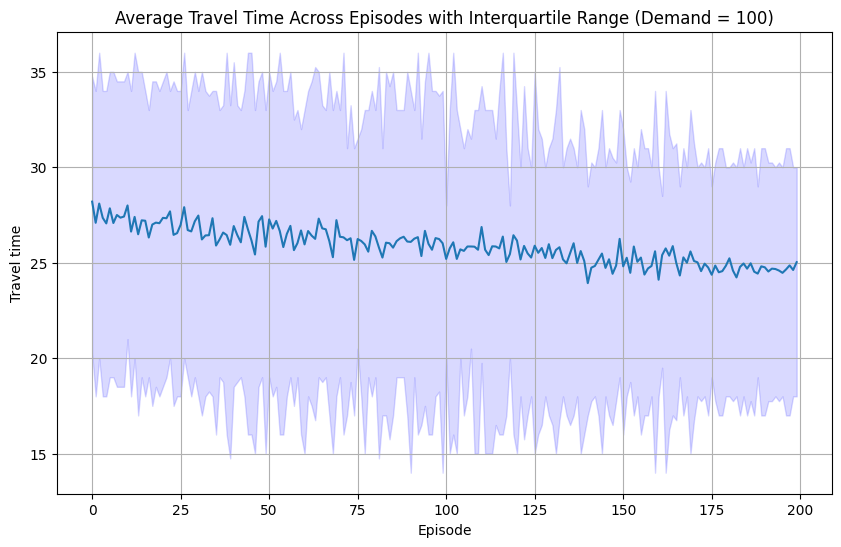

In [ ]:
# Plot the Figure
fig, ax = plt.subplots(figsize=(10,6))
x = range(len(df))
ax.plot(x, df_stat['avg'])
# ax.plot(x, df_stat['md'])
ax.fill_between(
    x, df_stat['1stQ'], df_stat['3rdQ'], color='b', alpha=.15)

ax.set_title('Average Travel Time Across Episodes with Interquartile Range (Demand = 100)')
ax.grid()
plt.xlabel('Episode')
plt.ylabel('Travel time')
plt.savefig('AvgTT100.png')

In [ ]:
# Load Reward Data
df_r_all = pd.read_csv('reward_scores_3.csv', index_col = 0)
df_r = df_r_all[300:]

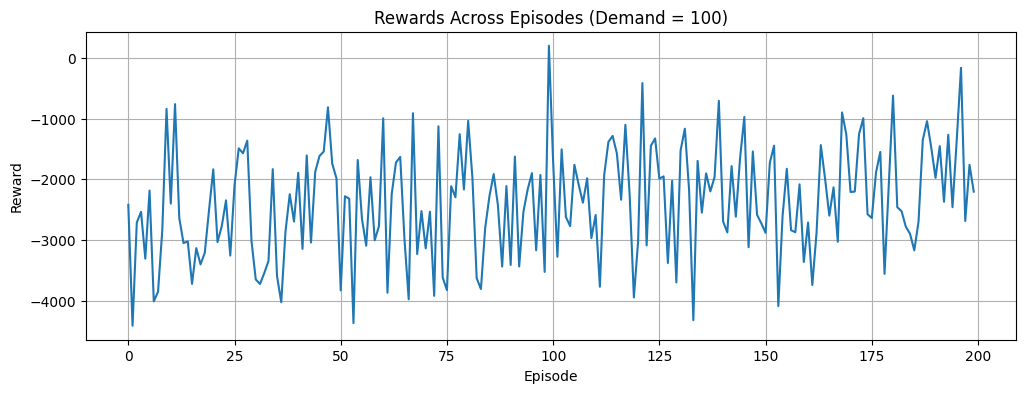

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
x = range(len(df_r))
ax.plot(x, df_r['0'])
ax.set_title('Rewards Across Episodes (Demand = 100)')
ax.grid()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig('Rewards100.png')

### High Demand (400 agents)

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
df1 = pd.read_csv('travel_times_50.csv', index_col = 0)
df2 = pd.read_csv('travel_times_80.csv', index_col = 0)
df = pd.concat([df1, df2], ignore_index=True)

In [ ]:
df_stat = pd.DataFrame()
df_stat['avg'] = df.mean(axis = 1)
df_stat['std'] = df.std(axis = 1)
df_stat['md'] = df.median(axis = 1)
df_stat['min'] = df.min(axis = 1)
df_stat['max'] = df.max(axis = 1)
df_stat['CI'] = df_stat['std'] * 1.96 / len(df.columns)
df_stat['IQR'] = df.quantile(0.75, axis = 1) - df.quantile(0.25, axis = 1)
df_stat['3rdQ'] = df_stat['md'] + df_stat['IQR']
df_stat['1stQ'] = df_stat['md'] - df_stat['IQR']
df_stat['upper'] = df_stat['avg'] + df_stat['CI']
df_stat['lower'] = df_stat['avg'] - df_stat['CI']
# df_stat

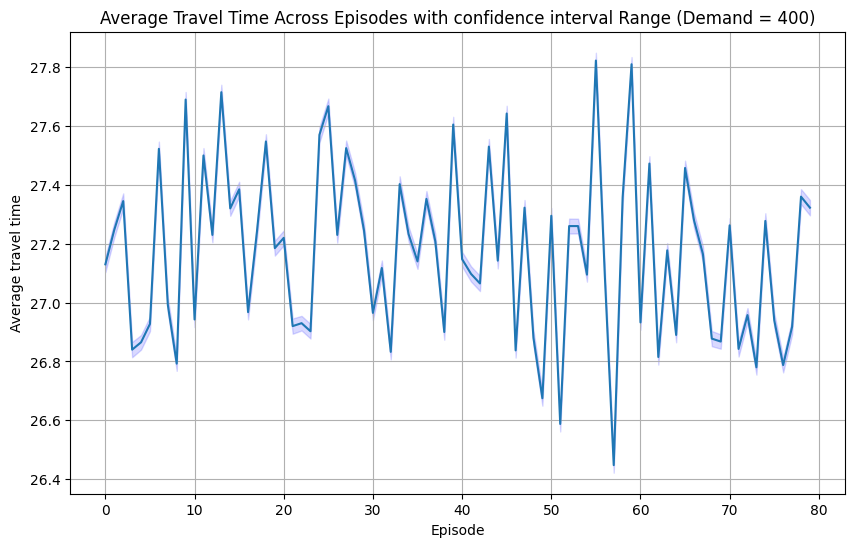

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
x = range(len(df))
ax.plot(x, df_stat['avg'])
# ax.plot(x, df_stat['md'])
ax.fill_between(
    x, df_stat['lower'], df_stat['upper'], color='b', alpha=.15)

ax.set_title('Average Travel Time Across Episodes with confidence interval Range (Demand = 400)')
ax.grid()
plt.xlabel('Episode')
plt.ylabel('Average travel time')
plt.savefig('AvgTT400.png')

In [ ]:
df_r = pd.read_csv('reward_80.csv')

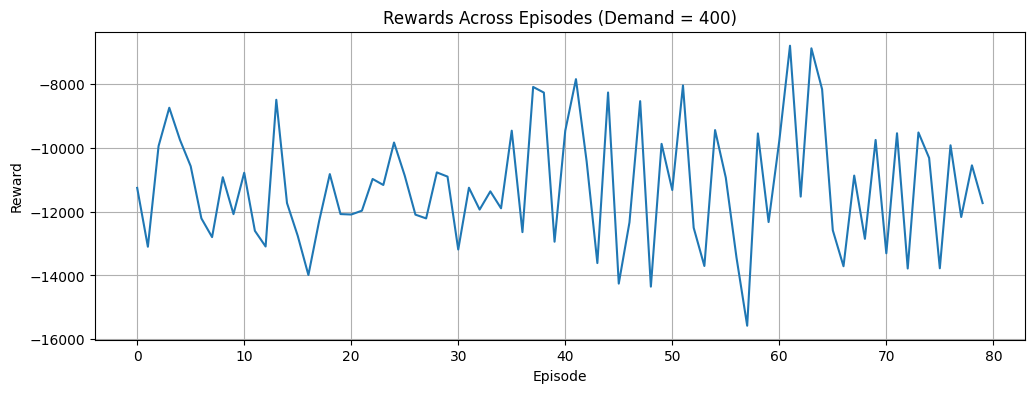

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
x = range(len(df_r))
ax.plot(x, df_r['0'])
ax.set_title('Rewards Across Episodes (Demand = 400)')
ax.grid()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig('Rewards400.png')

# References

* Camargo, P., Zill, J., & O’Brien, A. (2018). AequilibraE. 2018. https://www.aequilibrae.com/python/latest/
* Grunitzki, R., de Oliveira Ramos, G., & Bazzan, A. L. C. (2014, October). Individual versus difference rewards on reinforcement learning for route choice. In 2014 Brazilian Conference on Intelligent Systems (pp. 253-258). IEEE
* Lowe, R., Wu, Y. I., Tamar, A., Harb, J., Pieter Abbeel, O., & Mordatch, I. (2017). Multi-agent actor-critic for mixed cooperative-competitive environments. Advances in neural information processing systems, 30.
* Terry, J., Black, B., Grammel, N., Jayakumar, M., Hari, A., Sullivan, R., ... & Ravi, P. (2021). Pettingzoo: Gym for multi-agent reinforcement learning. Advances in Neural Information Processing Systems, 34, 15032-15043. https://pettingzoo.farama.org/api/parallel/
* Ramos, G. D. O., Bazzan, A. L., & da Silva, B. C. (2018). Analysing the impact of travel information for minimising the regret of route choice. Transportation Research Part C: Emerging Technologies, 88, 257-271.
* Sheffi, Y. (1985). Urban transportation networks (Vol. 6). Prentice-Hall, Englewood Cliffs, NJ
* Shou, Z., Chen, X., Fu, Y., & Di, X. (2022). Multi-agent reinforcement learning for Markov routing games: A new modeling paradigm for dynamic traffic assignment. Transportation Research Part C: Emerging Technologies, 137, 103560
* Zhou, B., Song, Q., Zhao, Z., & Liu, T. (2020). A reinforcement learning scheme for the equilibrium of the in-vehicle route choice problem based on congestion game. Applied Mathematics and Computation, 371, 124895

